<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/physicsAwareTransformer/blob/master/PAT/Inference_pat_local_receptive_field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PAT (local receptive field)

#### Qian Huang
#### Feb 6, 2023

The transformable receptive field of PAT also enables PATs to perform fusion without calibration data when two images are coarsely aligned. When one pixel in the alpha view only has a minor displacement to its associate pixel in the aligned beta view, PAT can wrap its receptive field resembling the convolutional kernel and integrate information from the neighborhood. As shown in this notebook, the pretrained PAT in [Section 4.1](https://arxiv.org/abs/2207.02250) composited the monochrome data and the
coarsely aligned color data of different resolution and focus states well.

*Acknowledgement*: Data `mh_pat_sample.zip` was from Minghao Hu, containing images to be tested and 5x5 neighborhood coordinates. Please refer to `mh_pat_sample/data_description.ipynb` for generation details.


In [1]:
### download required files

! git clone https://github.com/djbradyAtOpticalSciencesArizona/physicsAwareTransformer.git
! mv physicsAwareTransformer/PAT/* .
! unzip data/mh_pat_sample.zip

Cloning into 'physicsAwareTransformer'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 149 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (149/149), 40.88 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Archive:  data/mh_pat_sample.zip
   creating: mh_pat_sample/
   creating: mh_pat_sample/.ipynb_checkpoints/
  inflating: mh_pat_sample/.ipynb_checkpoints/data_description-checkpoint.ipynb  
   creating: mh_pat_sample/0000/
 extracting: mh_pat_sample/0000/hr.png  
 extracting: mh_pat_sample/0000/lr.png  
  inflating: mh_pat_sample/0000/x_h2l.npy  
  inflating: mh_pat_sample/0000/x_l2h.npy  
  inflating: mh_pat_sample/0000/y_h2l.npy  
  inflating: mh_pat_sample/0000/y_l2h.npy  
   creating: mh_pat_sample/0001/
 extracting: mh_pat_sample/0001/hr.png  
 extracting: mh_pat_sample/0001/lr.png  
  inflating: mh_pat_sample/0001/x_h2l.npy  
  inflating: mh_pa

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from PIL import Image

In [3]:
from models import *
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from utils import *
import argparse
import os
from torchvision import transforms

In [4]:
### load images

path = 'mh_pat_sample/'
prefix = '0000'
img0 = Image.open(f'{path}/{prefix}/hr.png')  ## hr monochrome image
img1 = Image.open(f'{path}/{prefix}/lr.png')  ## lr color image
img0  = np.array(img0,  dtype=np.float32)[..., np.newaxis].repeat(3, axis=2)
img1 = np.array(img1, dtype=np.float32)
img_rights = [img1]
m, n, c  = img0.shape
img0.shape, img1.shape

((532, 423, 3), (325, 259, 3))

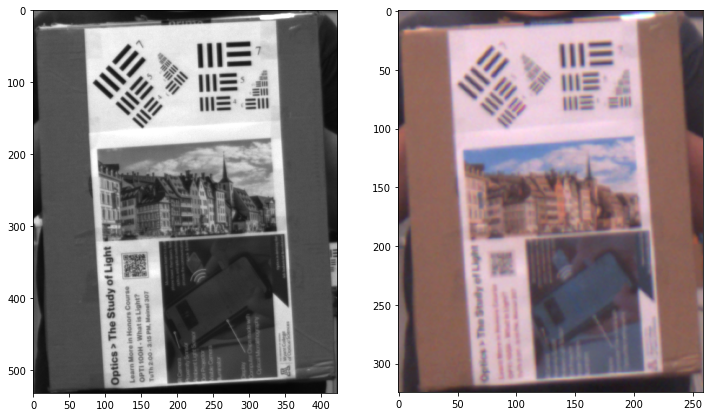

In [5]:
plt.figure(figsize=(12,10))
plt.subplot(1, 2, 1)
plt.imshow(img0/255.)
plt.subplot(1, 2, 2)
plt.imshow(img1/255.)
plt.show()

img1 was coarsely aligned to img0, bringing the beta correspondences to the vicinity of the alpha view pixels. The physical receptive field of PAT was 5 × 5 per voxel.

In [6]:
### transform numpy images to tensor images

def toTensor(img):
    img = torch.from_numpy(img.transpose((2, 0, 1)))
    return img.float().div(255)

x_left = toTensor(img0).unsqueeze(0).to('cuda')
x_rights = [toTensor(img_right).unsqueeze(0).to('cuda') for img_right in img_rights]

In [7]:
### load pretrained network

net = PAT(1, in_channel=3, num_input=2).to('cuda')
net = nn.DataParallel(net)
net.eval()
cudnn.benchmark = True
pretrained_dict = torch.load('log_2inputs/x4/best.pth.tar')
net.load_state_dict(pretrained_dict['state_dict'])

<All keys matched successfully>

In [8]:
### calculate features

with torch.no_grad():
    x_left = net.module.init_feature(x_left)
    x_rights = [net.module.init_feature(x_right) for x_right in x_rights]
    buffer_left = net.module.pam.rb(x_left)
    buffer_rights = [net.module.pam.rb(x_right) for x_right in x_rights]
    Q = net.module.pam.b1(buffer_left)
    Ss, Rs = [], []
    for i in range(len(buffer_rights)):
        Ss.append(net.module.pam.b2s[i](buffer_rights[i]))
        Rs.append(net.module.pam.b3s[i](buffer_rights[i]))

In [9]:
### load 5x5 neighborhood coordinates

xxs = np.load(f'{path}/{prefix}/x_h2l.npy')[np.newaxis]
yys = np.load(f'{path}/{prefix}/y_h2l.npy')[np.newaxis]
xxs.shape, yys.shape

((1, 532, 423, 25), (1, 532, 423, 25))

In [10]:
### calculate fused image

with torch.no_grad():
    fused_feature = torch.zeros((1, 128, m, n)).float().to('cuda')
    for i in range(1):
        for j in range(1):
            ID = i*1+j+1            
            print(ID)
            xl, xu, yl, yu = i*m, i*m+m, j*n, j*n+n

            
            Q_ = Q[:, :, xl:xu,yl:yu].contiguous()
            Pos = []

            xxs = np.load(f'{path}/{prefix}/x_h2l.npy')[np.newaxis]
            yys = np.load(f'{path}/{prefix}/y_h2l.npy')[np.newaxis]
            Pos.append((torch.from_numpy(xxs), torch.from_numpy(yys)))

            buffers = []
            for S, R, Po in zip(Ss, Rs, Pos):
#                 print(Q_.size(), S.size(), R.size(), Po[0].size())
                buffer, _ = net.module.pam.fe_pam(Q_, S, R, Po, False)
                buffers.append(buffer)
            buffers.append(x_left[:,:,xl:xu,yl:yu])
            fused_feature[:,:,xl:xu,yl:yu] = torch.cat(tuple(buffers), 1)
    out = net.module.pam.fusion(fused_feature)
    out = net.module.upscale(out)

1


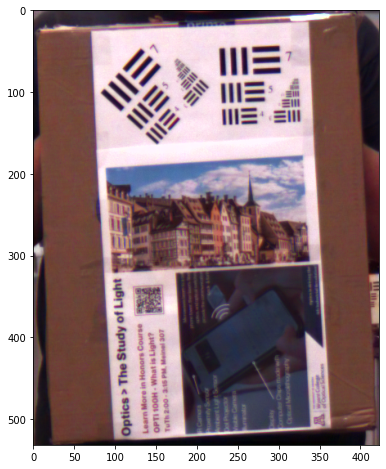

In [11]:
img = torch.clamp(out, 0, 1).squeeze().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

In [12]:
cv2.imwrite(f'results/mh{prefix}_pat_result.png', img[..., ::-1]*255.0)

True